In [1]:
from bs4 import BeautifulSoup
import jieba
import jieba.analyse
import pymongo
import pandas as pd
import numpy as np
import requests
import re
import json
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings 

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all' #默认为'last'

sns.set(style="white", context="talk")
sns.set(font="simhei")
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 23,
}

In [5]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
weibo_db = client["weibo"]
user_table = weibo_db['user']
post_table = weibo_db['post']
comment_table = weibo_db['comment']

In [ ]:
user_table.find_one{''}

In [4]:
post_list = [p for p in post_table.find()]
post_list = sorted(post_list, key=lambda x:x['_id'])
column_list = sorted(list(set(k for p in post_list for k in p.keys())))
post_df = pd.DataFrame(post_list,columns=column_list)
post_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15013 entries, 0 to 15012
Data columns (total 10 columns):
_id                15013 non-null int64
attitudes_count    15013 non-null int64
comments_count     15013 non-null object
created_at         15013 non-null object
isLongText         15013 non-null bool
page_info          10381 non-null object
reposts_count      15013 non-null object
source             15013 non-null object
text               15013 non-null object
uid                15013 non-null int64
dtypes: bool(1), int64(3), object(6)
memory usage: 1.0+ MB


In [5]:
attrs = ['attitudes_count','comments_count','reposts_count']

def convert(s):
    if isinstance(s,int):
        return s
    if s.startswith('100万'):
        return 100*10000+np.random.randint(200000)
    else:
        return 0
for attr in attrs:
    post_df[attr] = post_df[attr].apply(convert)

In [6]:
post_df.shape

(15013, 10)

In [7]:
post_df.head()

,_id,attitudes_count,comments_count,created_at,isLongText,page_info,reposts_count,source,text,uid
0,3725100329603408,0,0,2014-06-24,False,NaN,0,Android客户端,[好棒]I just wanna be happy. So I choose forgive...,1564245382
1,3725105421136472,1,0,2014-06-24,False,NaN,0,Android客户端,//<a href='/n/小米手机'>@小米手机</a>:😊,1564245382
2,3726195273566513,0,0,2014-06-27,False,NaN,0,Android客户端,"This is useful in office, keep it.//<a href='/...",1564245382
3,3726196259411034,0,0,2014-06-27,False,NaN,0,Android客户端,//<a href='/n/唐杰THU'>@唐杰THU</a>:icde很惨,1564245382
4,3726698199940562,0,0,2014-06-29,False,NaN,0,Android客户端,Repost,1564245382


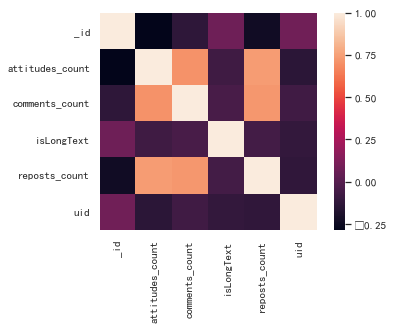

In [80]:
sns.heatmap(post_df.corr(), vmax=1, square=True)

In [81]:
post_df['is_report'] = post_df['text'].apply(lambda x:True if re.search(r'转发',x) else False)

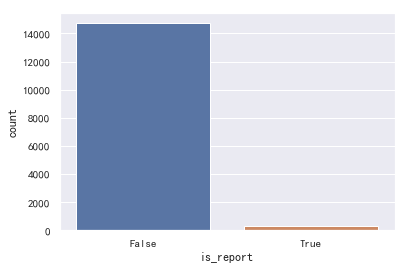

In [82]:
sns.countplot(x='is_report',data=post_df)

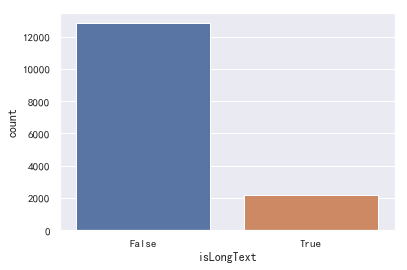

In [83]:
sns.countplot(x='isLongText',data=post_df)

In [84]:
post_df[['comments_count','attitudes_count','reposts_count']].cov()

,comments_count,attitudes_count,reposts_count
comments_count,6.647152e+09,5.469308e+09,1.047435e+10
attitudes_count,5.469308e+09,8.960701e+09,1.242484e+10
reposts_count,1.047435e+10,1.242484e+10,3.148289e+10


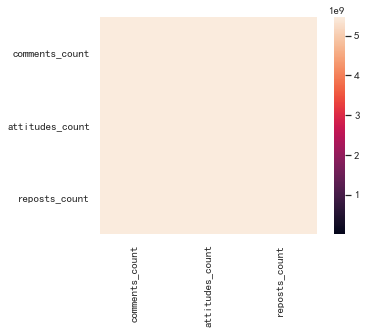

In [85]:
sns.heatmap(post_df[['comments_count','attitudes_count','reposts_count']].cov(), vmax=1, square=True)

<Figure size 5760x1440 with 0 Axes>

<Figure size 5760x1440 with 0 Axes>

<Figure size 5760x1440 with 0 Axes>

<Figure size 5760x1440 with 0 Axes>

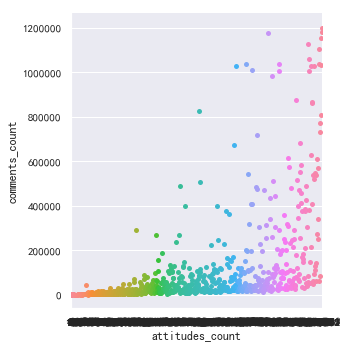

<Figure size 5760x1440 with 0 Axes>

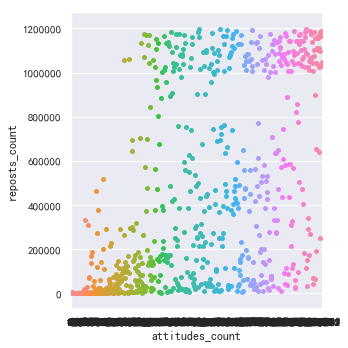

<Figure size 5760x1440 with 0 Axes>

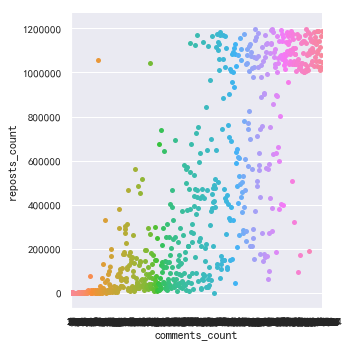

In [50]:
plt.figure(figsize=(80,20))
sns.catplot(x='attitudes_count',y='comments_count',data=post_df[:1000])

plt.figure(figsize=(80,20))
sns.catplot(x='attitudes_count',y='reposts_count',data=post_df[:1000])

plt.figure(figsize=(80,20))
sns.catplot(x='comments_count',y='reposts_count',data=post_df[:1000])

In [27]:
# 发微博大户
import_user_list = post_df['uid'].value_counts()[:20].index.tolist()

In [28]:
# user = post_df[post_df['uid']==2110705772]
# values = user['created_at'].value_counts()
# data = pd.DataFrame(values)
# name = user_table.find_one({'_id':2110705772})['screen_name']
# print(name)
# print('","'.join(data.index.values))
# data['created_at'].values

<Figure size 1440x14400 with 0 Axes>

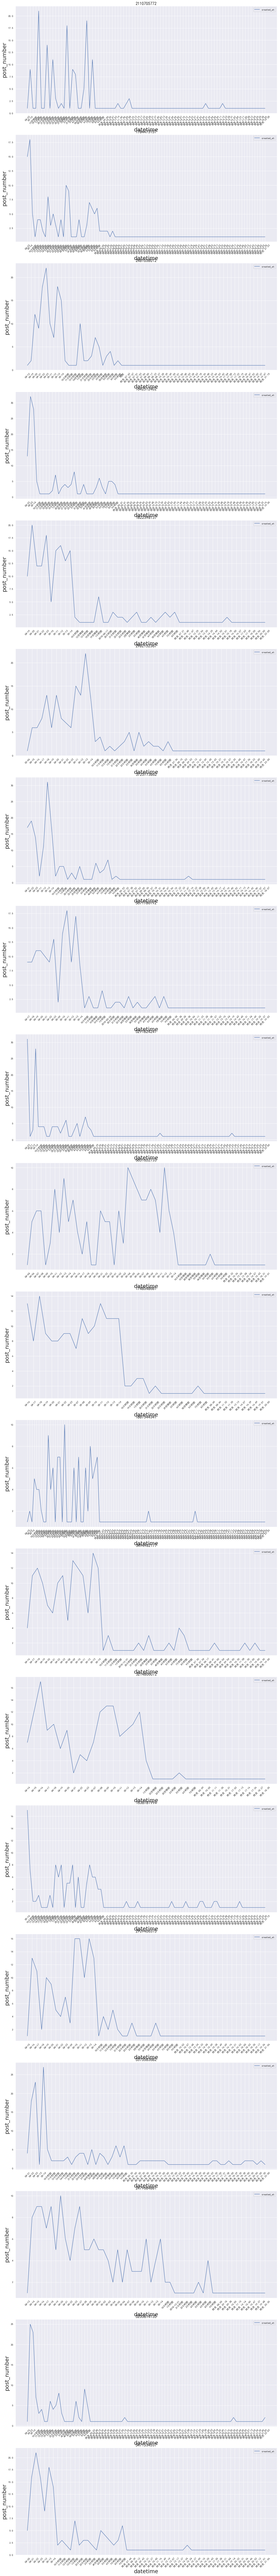

In [29]:
plt.figure(figsize=(20,10*len(import_user_list)))

for i,uid in enumerate(import_user_list,1):
    user = post_df[post_df['uid']==uid]
    values = user['created_at'].value_counts()
    data = pd.DataFrame(values)
    
    _ = plt.subplot(len(import_user_list),1,i)
    _ = plt.xticks(rotation=45)
    _ = plt.title(uid,fontsize=18)
    _ = plt.xlabel('datetime',font1)
    _ = plt.ylabel('post_number',font1)
    _ = sns.lineplot(data=data, linewidth=1.5)

<Figure size 5760x1440 with 0 Axes>

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

Text(0.5,0,'datetime')

Text(0,0.5,'post_number')

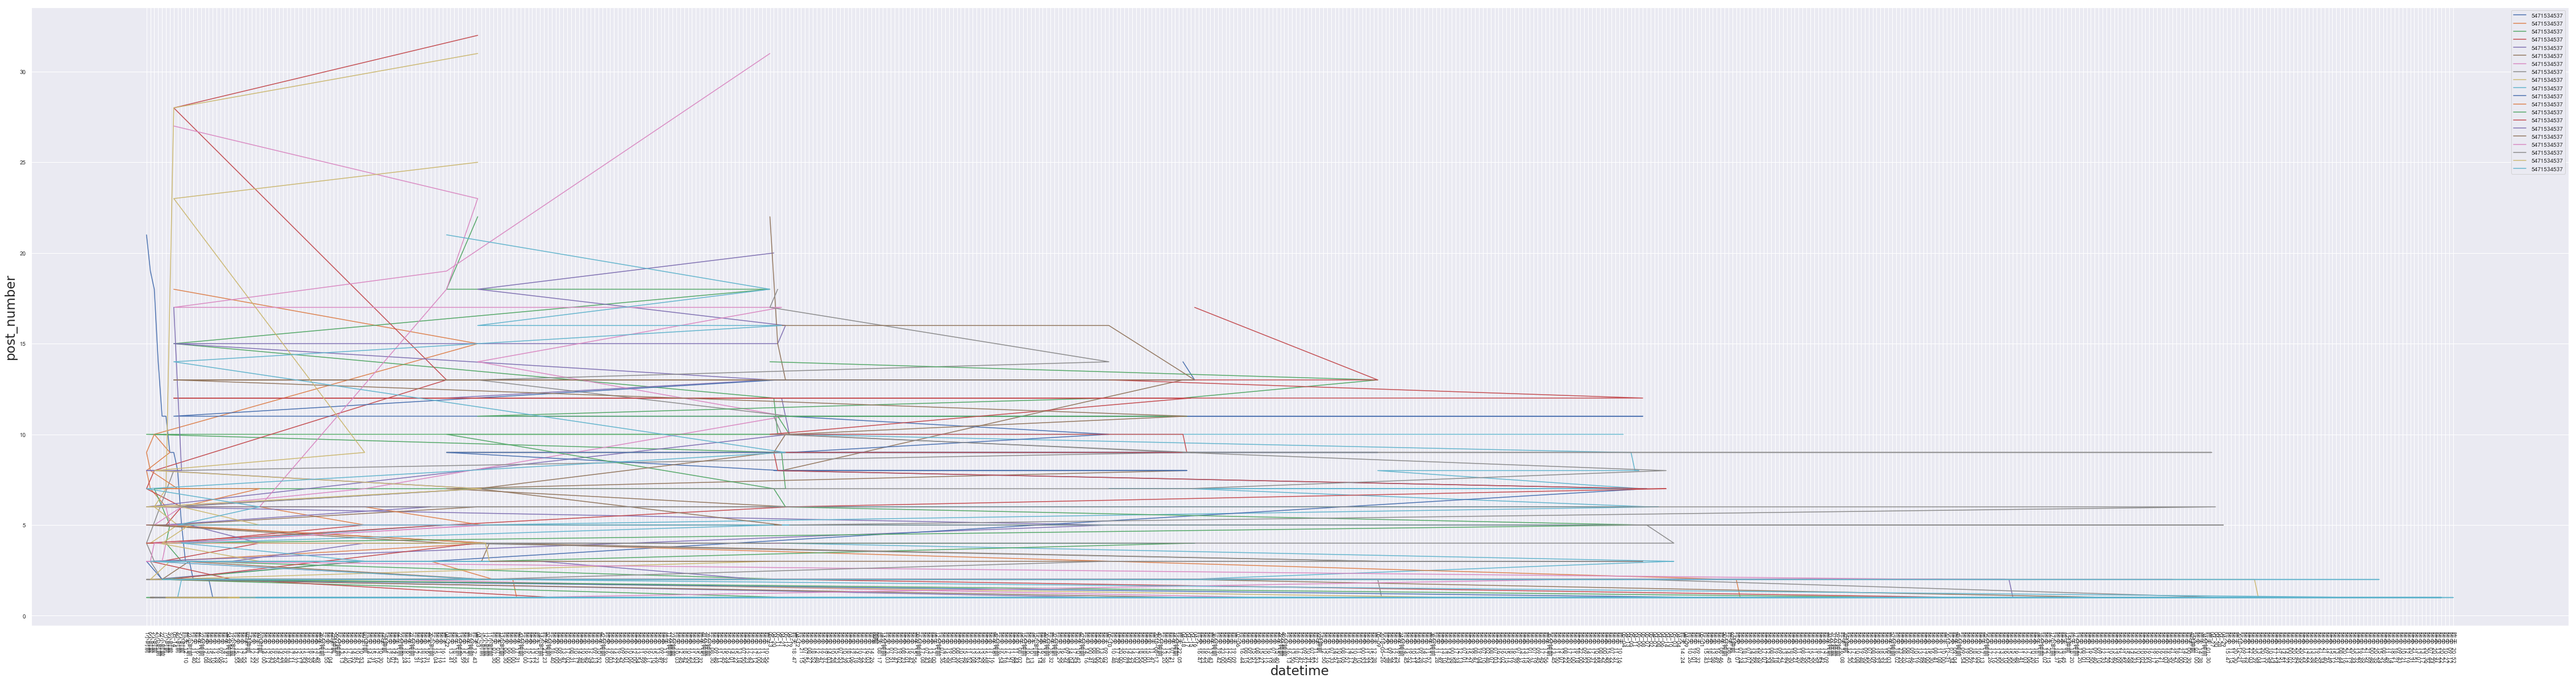

In [30]:
plt.figure(figsize=(80,20))
plt.xticks(rotation=-90)
plt.xlabel('datetime',font1)
plt.ylabel('post_number',font1)

df = pd.DataFrame(columns = ['time','created_at','uid'])

for i,uid in enumerate(import_user_list,1):
    user = post_df[post_df['uid']==uid]
    values = user['created_at'].value_counts()
    data = pd.DataFrame(values)
    data['uid']=uid
    data['time']=data.index
    _ = plt.plot(data['time'].values.tolist(),data['created_at'].values.tolist())
    _ = plt.legend(data['uid'].values.tolist())

<Figure size 1440x2160 with 0 Axes>

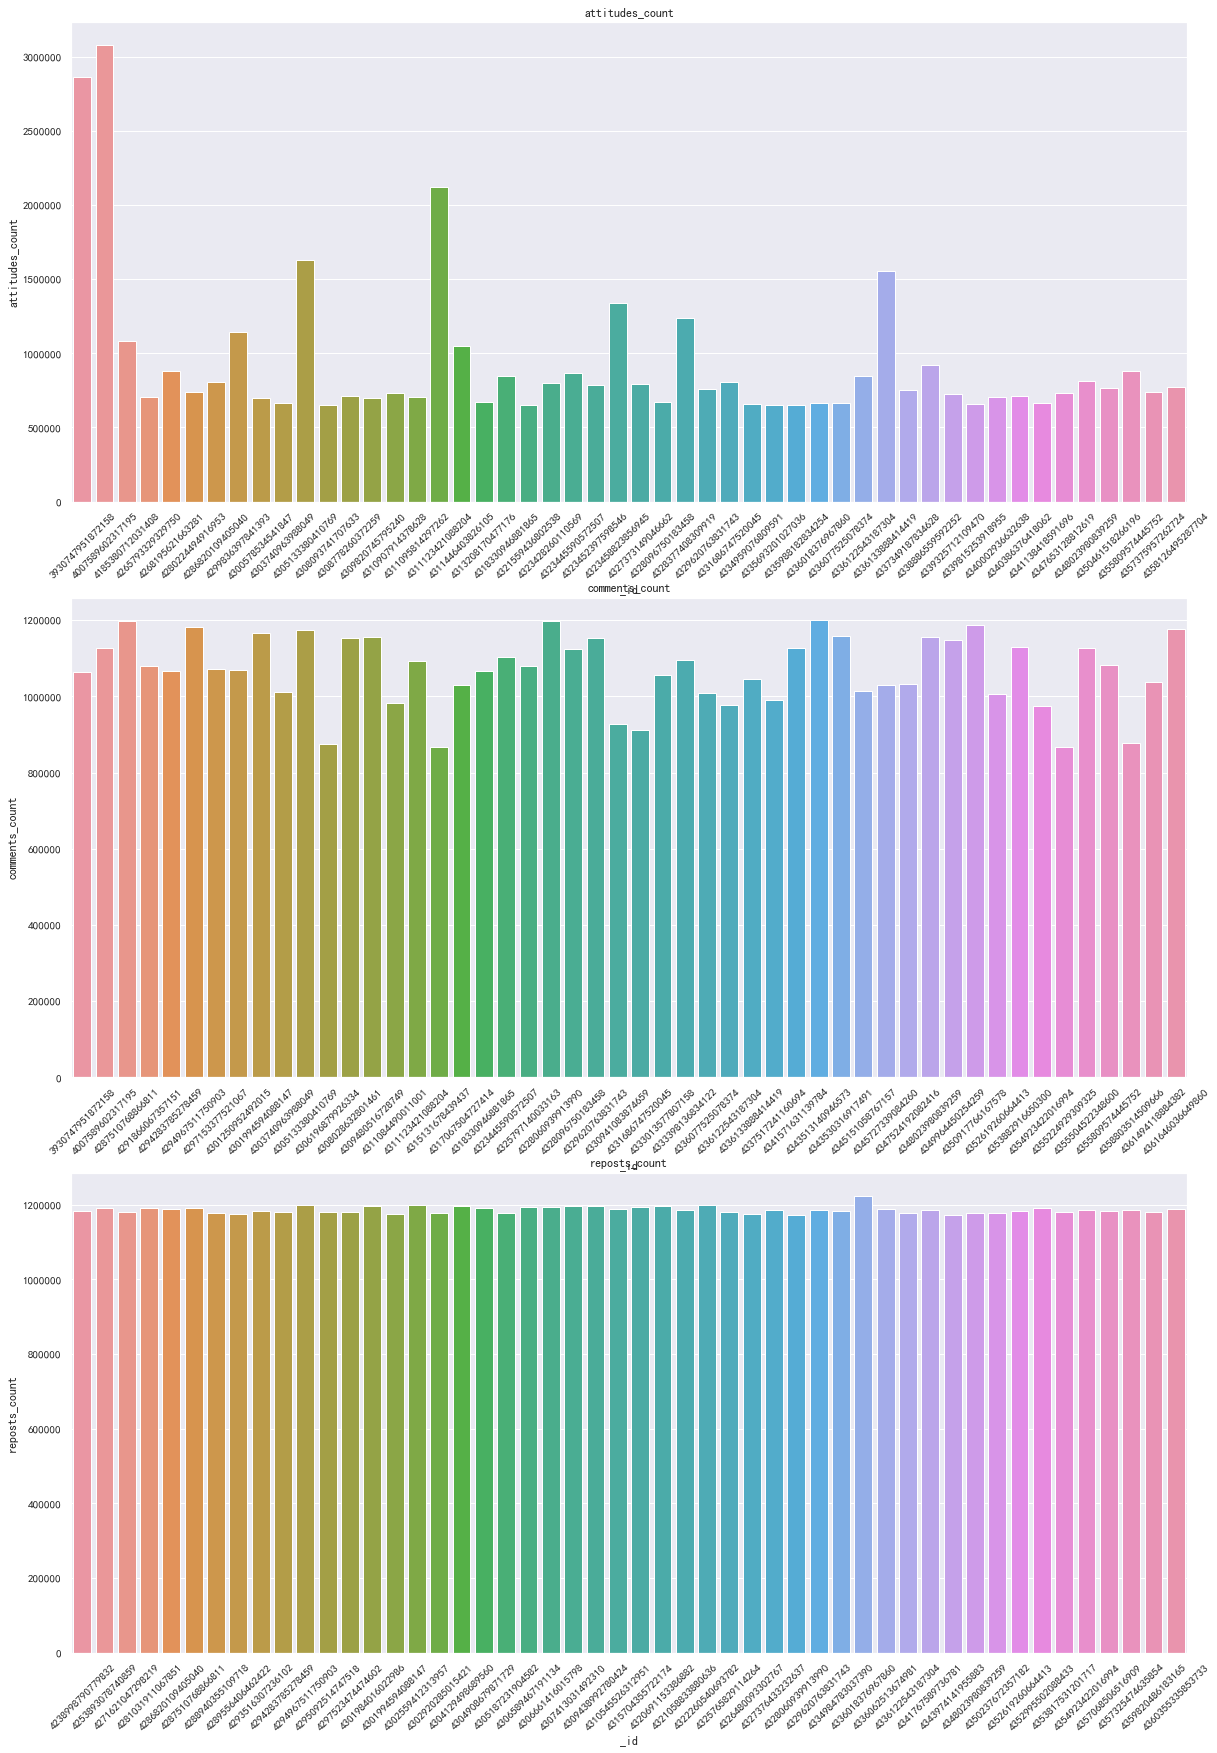

In [32]:
attrs = ['attitudes_count','comments_count','reposts_count']

plt.figure(figsize=(20,10*3))

for i,attr in enumerate(attrs):
    important_post_df = post_df.sort_values(attr,ascending=False)[:50]#每个属性都有较高水平的微博
    _ = plt.subplot(311+i)
    _ = plt.title(attr)
    _ = plt.xticks(rotation=45)
    _ = sns.barplot(x="_id", y=attr, data=important_post_df)

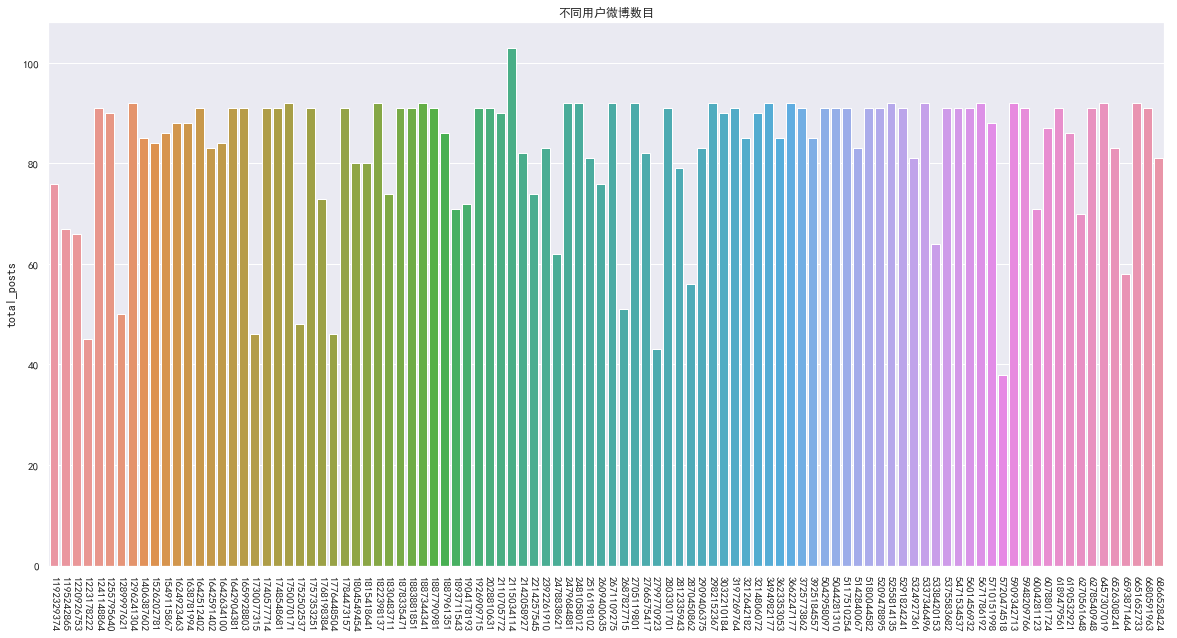

In [21]:
values = post_df['uid'].value_counts()[:100]
df = pd.DataFrame(values,values.index)
df.columns=['total_posts']

_ = plt.figure(figsize=(20,10))
_ = plt.title('不同用户微博数目')
_ = plt.xticks(rotation=-90)
_ = sns.barplot(x=df.index, y=df['total_posts'])

## 话题

In [8]:
topic_pattern = r'#[\u4e00-\u9fa5a-zA-Z0-9]+?#' 

In [22]:
total_topic_list = []
tmp = []
for p in post_list:
    topic_list = re.findall(topic_pattern,p['text'])
    if topic_list!=[]:
        pid = p['_id']
        uid = p['uid']
        total_topic_list.extend(topic_list)
        tmp.append([str(uid),str(pid),','.join(topic_list)])

In [23]:
topic_df = pd.DataFrame(total_topic_list)
topic_df.columns=['topic']

In [25]:
with open('topic.txt','w',encoding='utf-8') as f:
    for d in tmp:
        _ = f.write('\t'.join(d))
        _ = f.write('\n')

<Figure size 1440x720 with 0 Axes>

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

Text(0.5,1,'热门话题')

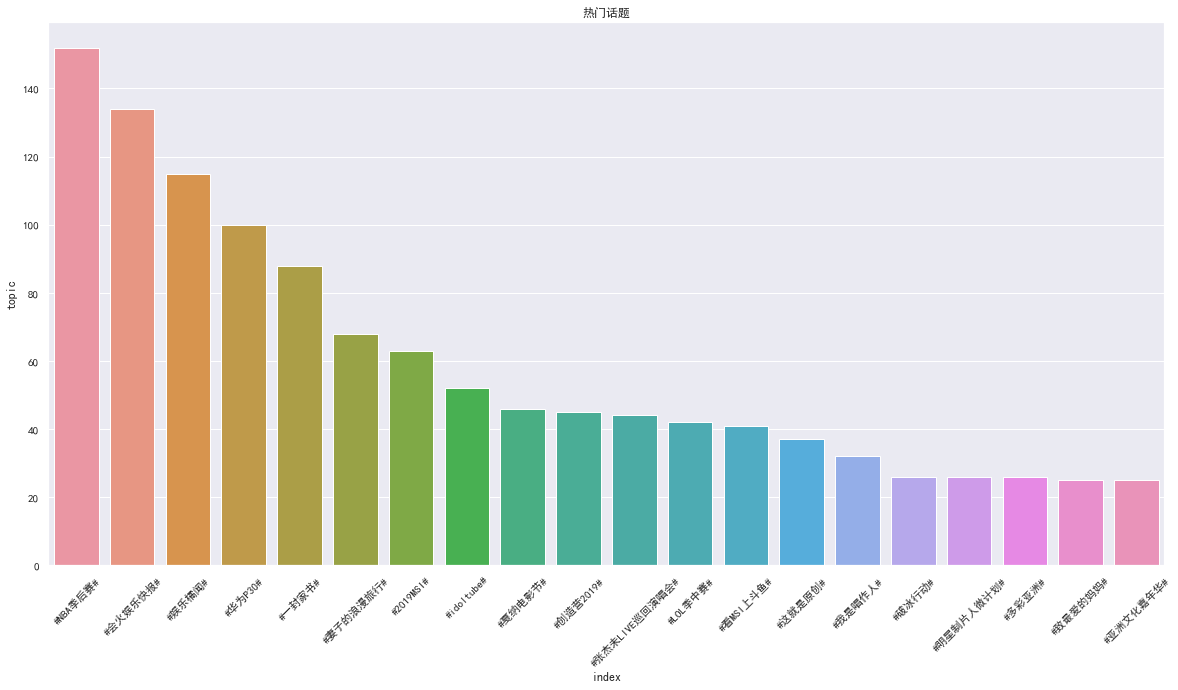

In [11]:
df = pd.DataFrame(topic_df['topic'].value_counts()[:20])
df.columns=['topic']
df['index']=df.index
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
plt.title('热门话题')
sns.barplot(data=df,x='index',y='topic')